In [15]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import animation
from IPython.display import HTML
import matplotlib

In [29]:
def merge_txt_files(data_path='data'):
    dfs = []
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        if file_path.endswith('.txt'):
            print(file_path)
            dfs.append(pd.read_csv(file_path, sep='\t'))
    df_concat = pd.concat(dfs)
    df_concat.to_csv(os.path.join('raw_data_merged.txt'), index=False, sep='\t')

def get_measures(traj):
    if sum(traj.ego_v<1):
        idx_slowdown = (traj.ego_v<0.5).to_numpy().nonzero()[0][0]
        bot_a_max = traj.bot_a.max()
        idx_bot_spawn = idx_slowdown + (traj[idx_slowdown:].bot_a<0.1*bot_a_max).to_numpy().nonzero()[0][0]
        throttle = traj.iloc[idx_bot_spawn:, traj.columns.get_loc('throttle')]
        idx_response = idx_bot_spawn + (throttle>0).to_numpy().nonzero()[0][0]
        RT = traj.t[idx_response] - traj.t[idx_bot_spawn]
        idx_min_distance = idx_bot_spawn + np.argmin(traj.d_ego_bot[idx_bot_spawn:].values)
        min_distance = min(traj.d_ego_bot[idx_bot_spawn:].values)
    else:
        idx_bot_spawn = -1
        idx_response = -1
        idx_min_distance = -1
        min_distance = -1
        RT = -1
    return pd.Series({'idx_bot_spawn': idx_bot_spawn,
                      'idx_response': idx_response,
                      'idx_min_distance': idx_min_distance,
                      'min_distance': min_distance,
                      'RT': RT})

def get_data(data_file='raw_data_merged.txt'):
    data = pd.read_csv(data_file, sep='\t', index_col=['subj_id', 'session', 'route', 'intersection'])
    data.loc[:,'t'] = data.t.groupby(data.index.names).transform(lambda t: (t-t.min()))/1000
    
    # we are only intersted in left turns
    data = data[data.turn_direction==1]

    # only consider parts of the trajectories near the target intersection
    data = data[abs(data.distance_to_intersection)<10]

    apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
    cols_to_smooth = ['ego_x', 'ego_y', 'ego_vx', 'ego_vy', 'ego_ax', 'ego_ay', 
                      'bot_x', 'bot_y', 'bot_vx', 'bot_vy', 'bot_ax', 'bot_ay']
    data.loc[:, cols_to_smooth] = (data.loc[:, cols_to_smooth].groupby(data.index.names).transform(apply_filter))

    data['ego_v'] = np.sqrt(data.ego_vx**2 + data.ego_vy**2)
    data['bot_v'] = np.sqrt(data.bot_vx**2 + data.bot_vy**2)

    data['ego_a'] = np.sqrt(data.ego_ax**2 + data.ego_ay**2)
    data['bot_a'] = np.sqrt(data.bot_ax**2 + data.bot_ay**2)
    
    data['d_ego_bot'] = np.sqrt((data.ego_x - data.bot_x)**2 + (data.ego_y - data.bot_y)**2)
    
    data['tta'] = data.d_ego_bot/data.bot_v
    
    measures = data.groupby(data.index.names).apply(get_measures)
    
    data = data.join(measures)
    
    # RT is -1 if a driver didn't stop, we discard these trials
    data = data[data.RT>0]
    measures = measures[measures.RT>0]    
    
    conditions = data.loc[:,['tta_condition', 'd_condition', 'v_condition']].groupby(data.index.names).first()
    measures = measures.join(conditions)

    return data, measures

In [3]:
merge_txt_files()

data\120_1_2019_08_20_15_35.txt
data\305_1_2019_08_20_14_43.txt


In [76]:
data, measures = get_data()
subjects = data.index.get_level_values(0).unique()

# column p(turn) (probability of turn) is set to True 
# if the cars were no closer to each other than lane width (3.5m + 1.5 margin just in case)
# this works based on visual inspection of animations for all trials
measures['p(turn)'] = measures.min_distance > 5
# measures_turn = measures[measures['p(turn)']>0]

## temporary fixes for the pre-pilot data
# tta was recorded as int, not float, so it was actually 4.5, not 4s
data.loc[data['tta_condition']==4.0, 'tta_condition'] += 0.5
# in one trial, the subject decided to turn but crashed, so the min_distance criterion didn't work
measures.loc[(305, 1, 1, 8), ['p(turn)']] = True

We only have very little data so far, 59 decisions from 2 pilot subjects. This data can only help to fine-tune the parameteres of the experiment setup, we cannot yet draw any conclusions regarding our hypotheses

In [21]:
measures.describe()

idx_bot_spawn  idx_response  idx_min_distance  min_distance         RT  \
count      59.000000     59.000000         59.000000     59.000000  59.000000   
mean       81.610169    255.322034        476.966102     18.040371   1.784847   
std        26.045065    136.725681        126.100667     19.276584   1.431894   
min        22.000000    117.000000        326.000000      2.679920   0.257000   
25%        60.500000    153.000000        406.000000      3.302941   0.690000   
50%        81.000000    190.000000        448.000000      3.577510   1.059000   
75%       104.000000    311.000000        533.000000     36.617662   2.402500   
max       128.000000    691.000000       1133.000000     58.849186   6.359000   

       tta_condition  d_condition  v_condition  
count      59.000000     59.00000    59.000000  
mean        4.525424    120.00000    28.152542  
std         1.260896     30.62566    10.741177  
min         3.000000     80.00000    13.000000  
25%         3.000000     80.00000    20.000000  
50%         4.500000    120.00000    26.000000  
75%         6.000000    160.00000    35.000000  
max         6.000000    160.00000    53.000000

Let's take a look at an example trajectory

In [53]:
traj_id = (subjects[0],1,1,11)
traj = data.loc[traj_id]

In [56]:
def animate_traj(traj):
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response) - idx_bot_spawn
    tta = traj.iloc[0].tta_condition
    d = (np.sqrt((traj.ego_x[idx_bot_spawn]-traj.bot_x[idx_bot_spawn])**2 
                 + (traj.ego_y[idx_bot_spawn]-traj.bot_y[idx_bot_spawn])**2))
    v = d/tta
    min_distance = traj.iloc[0].min_distance
    dt = traj.t.diff().median()  
    
    traj_to_plot = traj[idx_bot_spawn:]    
    
    fig, ax = plt.subplots()
    
    margin = 5
    ax.set_xlim(( min(traj_to_plot.ego_x.min(), traj_to_plot.bot_x.min()) - margin, 
                 max(traj_to_plot.ego_x.max(), traj_to_plot.bot_x.max()) + margin))
    ax.set_ylim(( min(traj_to_plot.ego_y.min(), traj_to_plot.bot_y.min()) - margin, 
                 max(traj_to_plot.ego_y.max(), traj_to_plot.bot_y.max()) + margin))  

    marker_ego, = ax.plot([], [], marker='o', ls='', color='C0', label='ego')
    marker_bot, = ax.plot([], [], marker='s', ls='', color='C1', label='bot')
    line_ego, = ax.plot([], [], lw=2, ls='-', color='C0')
    line_bot, = ax.plot([], [], lw=2, ls='-', color='C1')

    def animate(i):
        marker_ego.set_data(traj_to_plot.ego_x[i], traj_to_plot.ego_y[i])
        marker_bot.set_data(traj_to_plot.bot_x[i], traj_to_plot.bot_y[i])
        line_ego.set_data(traj_to_plot.ego_x[:i], traj_to_plot.ego_y[:i])
        line_bot.set_data(traj_to_plot.bot_x[:i], traj_to_plot.bot_y[:i])

        return (marker_ego, marker_bot, line_ego, line_bot,)
    
    legend = ax.legend(fontsize=12)
    ax.set_title('$t=0$: TTA=%.1fs, d=%im, v=%.2fm/s, min_d=%.1fm' % (tta, d, v, min_distance), fontsize=14)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(traj_to_plot), interval=int(1000*dt), blit=True)
    return anim

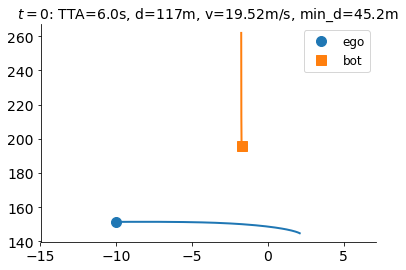

In [77]:
anim = animate_traj(traj)
# HTML(anim.to_html5_video())
HTML(anim.to_jshtml())

To check whether the classification of the turning decision makes sens, save animations for all trials in the folders according to the minimum distance ever observed between ego and bot

In [57]:
for name, traj in data[data.min_distance<5].groupby(data.index.names):
    anim = animate_traj(traj)
    anim.save('figures/wait/%s.mp4' % (str(traj.iloc[0].name)), dpi=300)
    plt.close()

In [61]:
for name, traj in data[data.min_distance>5].groupby(data.index.names):
    anim = animate_traj(traj)
    anim.save('figures/turn/%s.mp4' % (str(traj.iloc[0].name)), dpi=300)
    plt.close()

Take a look at the time course of the trials to see if the times of bot spawn (start of decision) and response (termination of a decision) are determined correctly

In [78]:
def plot_traj(traj):    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    
    fig, axes = plt.subplots(4, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color='C0')
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color='C7', ls='', marker='x')
    axes[0].set_ylabel('ego v')

    axes[1].plot(traj.t, traj.throttle, color='C1')
    axes[1].plot(traj.t[idx_bot_spawn], traj.throttle[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[1].plot(traj.t[idx_response], traj.throttle[idx_response], color='C7', ls='', marker='x')
    axes[1].set_ylabel('ego throttle')

    axes[2].plot(traj.t[:], traj.d_ego_bot[:], color='C2')
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color='C7', ls='', marker='x')
    axes[2].set_ylabel('d(ego to bot)')

    axes[3].plot(traj.t[:], traj.tta[:], color='C3')
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color='C7', ls='', marker='o', 
                 label='Oncoming car appears')
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color='C7', ls='', marker='x', 
                 label='Decision is made')
    axes[3].set_ylabel('tta')
    axes[3].set_ylim((0, 7))

    axes[3].set_xlabel('time $t$')

    legend = fig.legend(loc='upper left', bbox_to_anchor=(1.0, 0.9), title=str(traj.iloc[0].name))
    legend.get_title().set_fontsize('18')
    plt.tight_layout()
    plt.savefig('figures/%s.png' % (str(traj.iloc[0].name)))

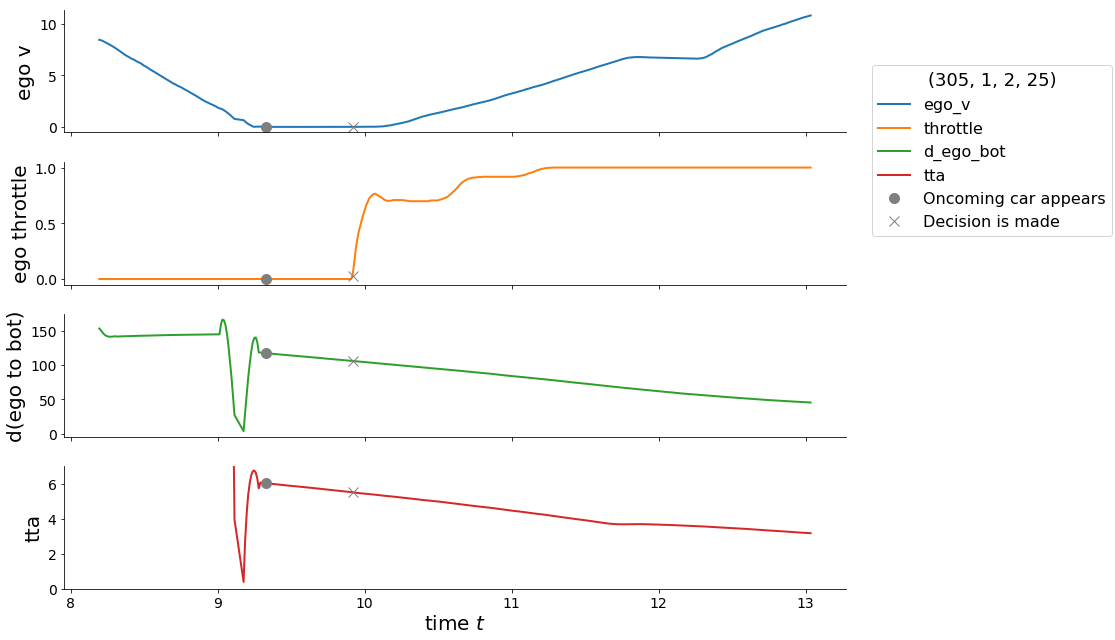

In [79]:
plot_traj(traj)

Save plots for all trajectories

In [351]:
for name, traj in data.groupby(data.index.names):
    plot_traj(traj)
    plt.close()

# Measures analysis

In [80]:
measures = measures.reset_index()
measures_turn = measures_turn.reset_index()

We need to determine whether the TTA conditions used for the pilot allow us to capture both "clear cut" and "borderline" decisions. For this, we take a look at whether p(turn) and RT are sensitive to TTA in the two subjects that we have had so far

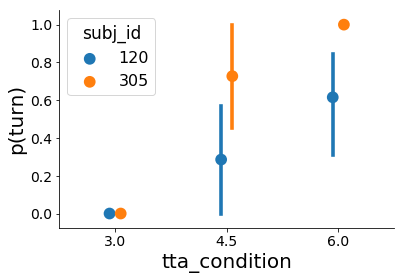

In [81]:
sns.pointplot(data=measures, x='tta_condition', y='p(turn)', hue='subj_id', join=False, dodge=0.1)

Based on the p(turn) plot, we can already see individual differences in sensitivity to TTA. Maybe use a staircase procedure?

Now let's see if there are any abnormalities in the RTs. We could already see in some trials that in "wait" decisions RT is very short because of "changes-of-mind", but so far we focus on the "turn" decisions, so we can ignore "wait" RTs altogether. Still, it's intersting to see RTs for all trials (but bear in mind that "wait" trials will have weird RTs)

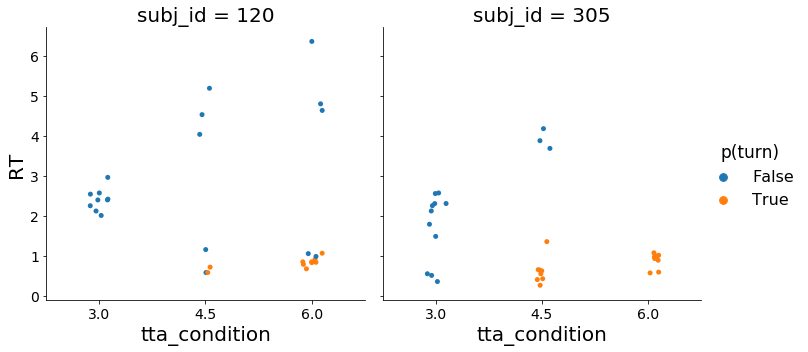

In [87]:
grid = sns.catplot(data=measures, x='tta_condition', y='RT', col='subj_id', hue='p(turn)')

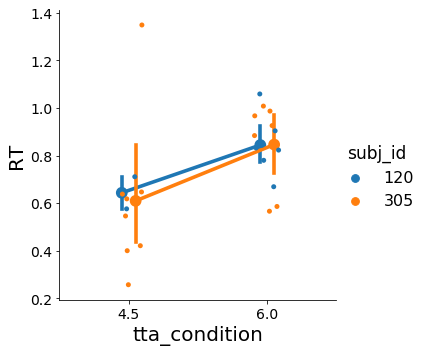

In [99]:
grid = sns.catplot(data=measures_turn, x='tta_condition', y='RT', hue='subj_id')
ax = grid.axes[0][0]
sns.pointplot(data=measures_turn, x='tta_condition', y='RT', hue='subj_id', ax=ax, alpha=0.5, dodge=0.1)
ax.legend().remove()

We can look at the outliers to see if there's something weird there

In [95]:
measures[(measures.RT<0.4) & (measures['p(turn)']==True)]

subj_id  session  route  intersection  idx_bot_spawn  idx_response  \
41      305        1      1            21          114.0         139.0   

    idx_min_distance  min_distance     RT  tta_condition  d_condition  \
41             434.0     41.236759  0.257            4.5          160   

    v_condition  p(turn)  
41           35     True

We also are not sure about whether TTA is the right perceptual quantity that describes the information that the drivers use when making a decision. It can be, for instance, another combination of d and v. Let's take a look at the distance, for instance

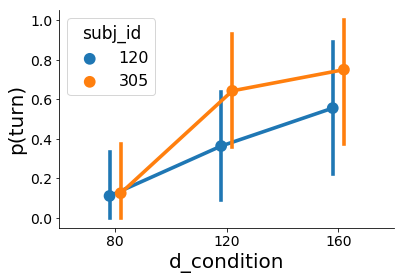

In [97]:
sns.pointplot(data=measures, x='d_condition', y='p(turn)', hue='subj_id', join=True, dodge=0.1)

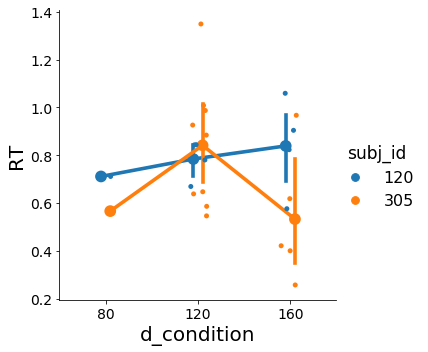

In [100]:
grid = sns.catplot(data=measures_turn, x='d_condition', y='RT', hue='subj_id')
ax = grid.axes[0][0]
sns.pointplot(data=measures_turn, x='d_condition', y='RT', hue='subj_id', ax=ax, alpha=0.5, dodge=0.1)
ax.legend().remove()

It doesn't seem that distance is a stronger predictor of p(turn) or RT compared to TTA, which is in contrast to the literature on gap acceptance (e.g. Davis & Swenson 2004, who found that the opposite is true). Look into that?